# Levelling Up
This code demonstrates new forms of fairness that 'level-up'. That is they improve measures such as recall rate or selection rates for disadvantaged groups. This is a change from standard measures of fairness that equalize harms across groups (and consequentially 'level down' and decrease rates for some groups, and harms them  more than they were harmed by the original classifier).

More details are in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4331652).

We compare conventional fairness algorithms that can increase the harm to some groups in the name of equality, against new approaches that only decrease the harm to individuals.

The code here reproduces the plots in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4331652).


In [1]:
# Load and train a baseline classifier
import matplotlib.pyplot as plt
from autogluon.tabular import TabularDataset, TabularPredictor
from oxonfair import FairPredictor 
from oxonfair.utils import group_metrics as gm
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
predictor = TabularPredictor(label='class').fit(train_data=train_data,time_limit=5)


/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20240611_073129"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 5s
AutoGluon will save model

In [2]:
# Set grid_width to 1000 to reproduce the plots in the paper exactly. 
# Setting it to False will give the default run-time, at the cost of slightly less detailed plots. 
grid_width = (False,1000)[1]

In [3]:
#Enforcing demographic parity
# Modify predictor to enforce fairness over the train_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Down: Demographic Parity vs Accuracy trade-off')

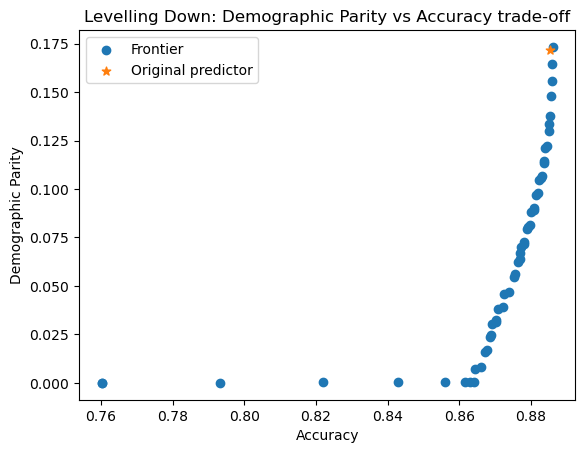

In [4]:

fpredictor.plot_frontier(objective1=gm.demographic_parity,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Down: Demographic Parity vs Accuracy trade-off')

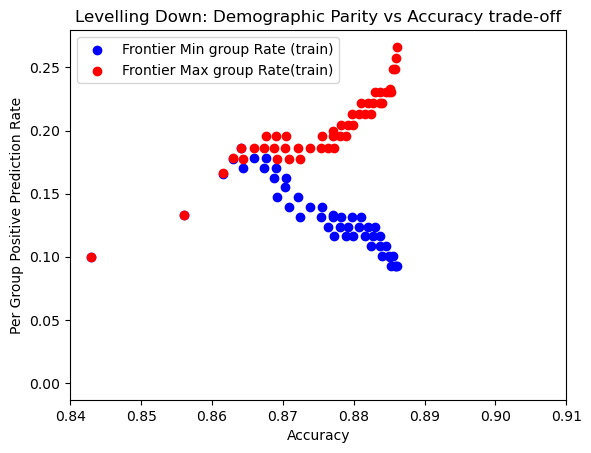

In [5]:
#Plot an overlay of the selection rate for each group as we vary the accuracy/demographic parity trade-off
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
# uncomment the following two lines to additionally plot on test data
#fpredictor.plot_frontier(test_data,objective1=gm.pos_pred_rate.min,objective2=gm.accuracy,new_plot=False, color='brown')
#fpredictor.plot_frontier(test_data,objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='pink')
plt.xlim(0.84,0.91)
plt.title('Levelling Down: Demographic Parity vs Accuracy trade-off')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate (train)', 'Frontier Max group Rate(train)',
            'Frontier Min group Rate (test)', 'Frontier Max group Rate(test)'))

In [6]:
#Contrast with `Leveling-up' and enforcing a minimum selection rate for each group 
fpredictor.fit(gm.accuracy,gm.pos_pred_rate.min,0.275,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

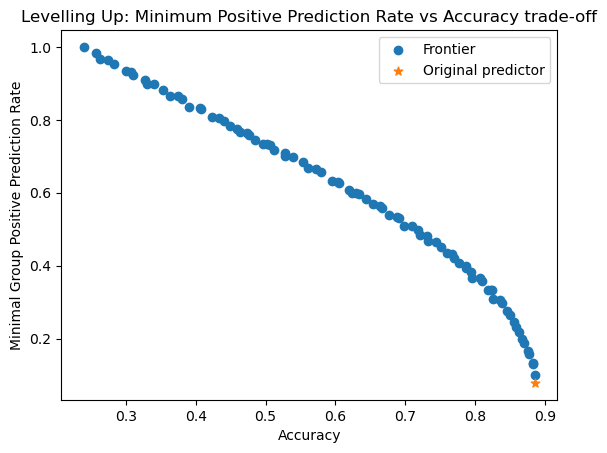

In [7]:
#Plot the new frontier
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

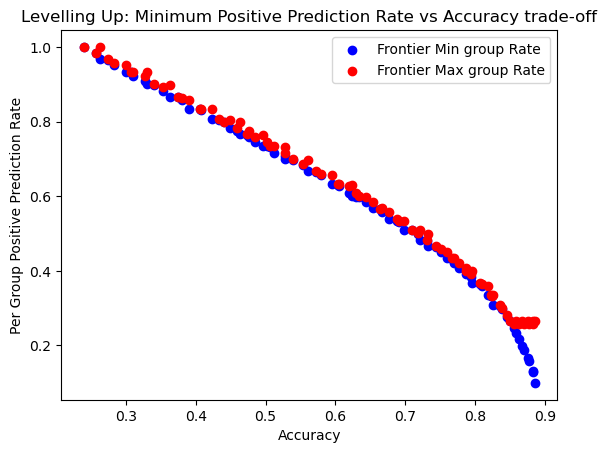

In [8]:
#Plot the new frontier for each group
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate', 'Frontier Max group Rate',))

Text(0.5, 1.0, 'Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

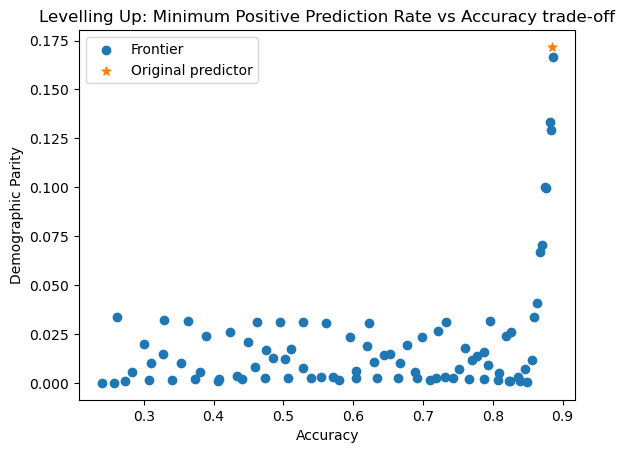

In [9]:
#Plot the new frontier with respect to demographic parity
fpredictor.plot_frontier(objective1=gm.demographic_parity,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')


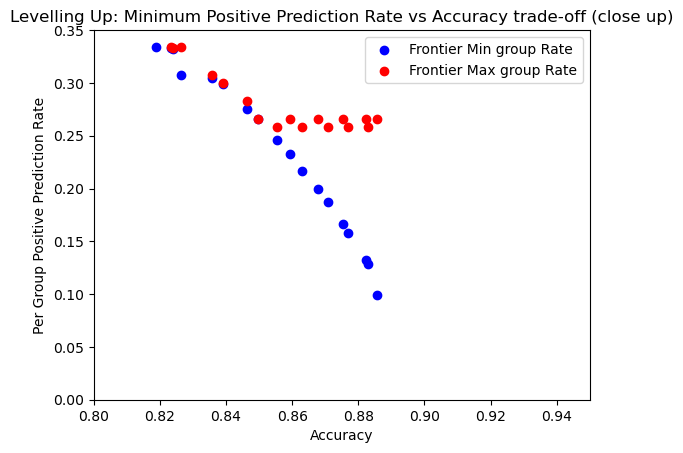

In [10]:
# Plot a detail of the behaviour of the frontier with respect to each group
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.ylim(0,0.35)
plt.xlim(0.8,0.95)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off (close up)')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate','Frontier Max group Rate',))

In [11]:
#Do the same thing but for true negative difference. This fairness measure is analgous to equal opportunity but with the target label flipped.
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the equal opportunity (the difference in recall rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.true_neg_rate.diff,0.02,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Down: Difference in True Negative Rate vs Accuracy trade-off')

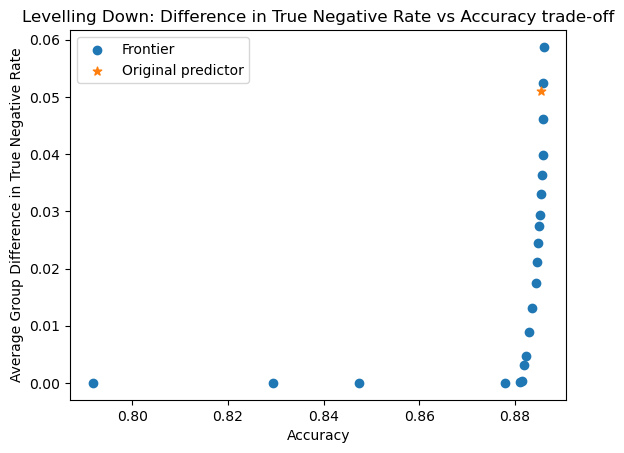

In [12]:
#plot the accuracy/true negative rate trade-off
import matplotlib.pyplot as plt
fpredictor.plot_frontier(objective1=gm.true_neg_rate.diff,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Down: Difference in True Negative Rate vs Accuracy trade-off')


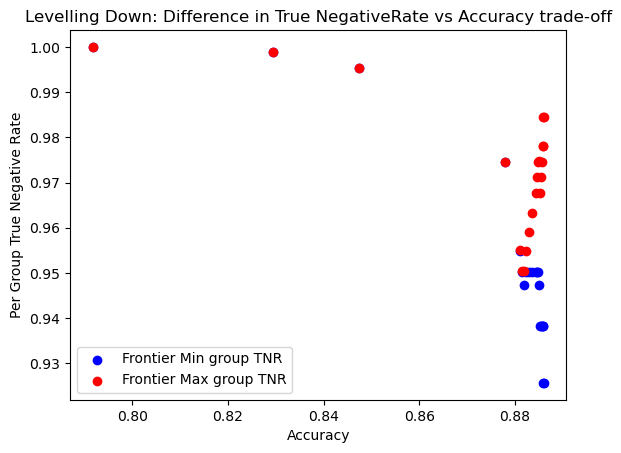

In [13]:
# plot the trade-off for each group 
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.true_neg_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
#plt.xlim(0.89,0.91)
#plt.ylim(0.8,1)
plt.title('Levelling Down: Difference in True NegativeRate vs Accuracy trade-off')
plt.ylabel('Per Group True Negative Rate')
plt.legend(('Frontier Min group TNR','Frontier Max group TNR',))

In [14]:
#Instead perform levelling up, by increasing the minimal true negative rate per group
fpredictor.fit(gm.accuracy,gm.true_neg_rate.min,0.99,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')

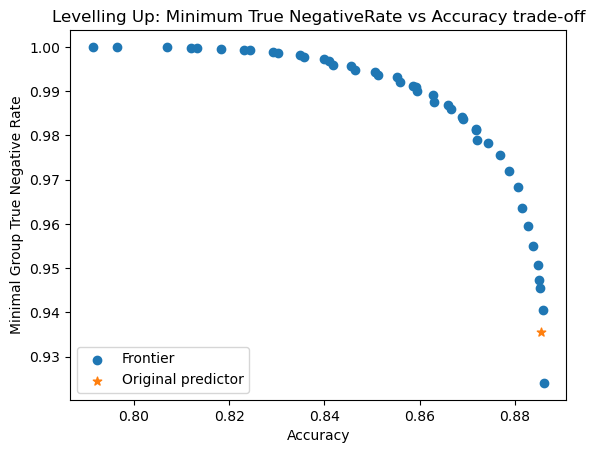

In [15]:
#plot
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')


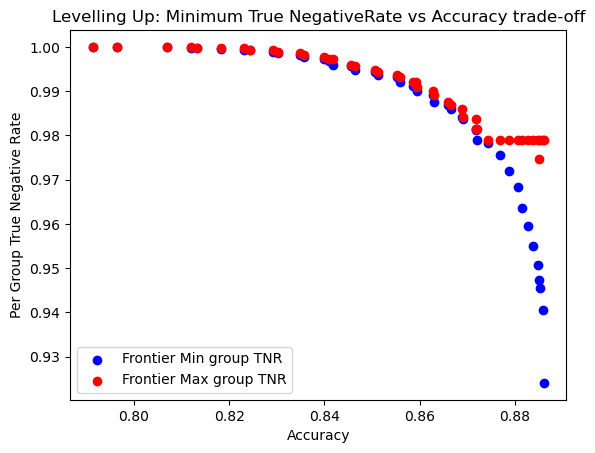

In [16]:
#Plot per group trade-off
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.true_neg_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')
plt.ylabel('Per Group True Negative Rate')
plt.legend(('Frontier Min group TNR','Frontier Max group TNR'))

Text(0.5, 1.0, 'Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')

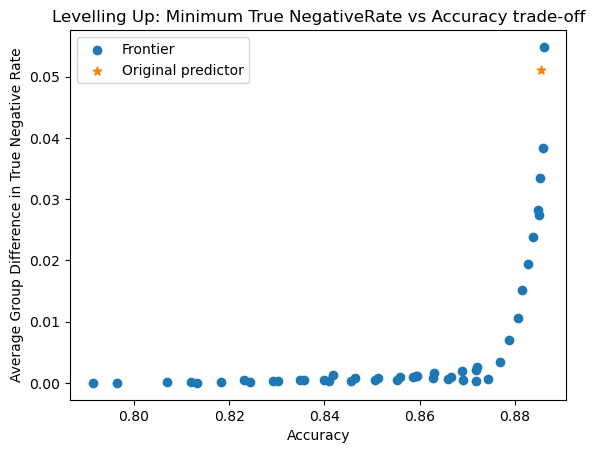

In [17]:
#Plot difference in true negative rate vs accuracy for the new pareto frontier
fpredictor.plot_frontier(objective1=gm.true_neg_rate.diff,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')
